In [84]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [85]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [86]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [87]:
data_copy = king_all_copy
print(data_copy['date'])
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

0       1939-01-01
1       1939-01-02
2       1939-01-03
3       1939-01-04
4       1939-01-05
           ...    
24364   2020-12-25
24365   2020-12-26
24366   2020-12-27
24367   2020-12-28
24368   2020-12-29
Name: date, Length: 24369, dtype: datetime64[ns]


,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [88]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [89]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [90]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [91]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [92]:
master_data = master_data[132:]

In [93]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [94]:
master_data.reset_index(inplace=True)

In [95]:
master_data = master_data.drop(labels='index', axis=1)

In [96]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


<h2>Load Covariate Data and Concat to Master_Data</h2>

In [97]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [98]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
chris_path_cov = '/Users/chrisshell/Desktop/Stanford/SalmonData/Environmental Variables/salmon_env_use.csv'
abdul_path_cov= '/Users/abdul/Downloads/SalmonNet/salmon_env_use.csv'
cov_data = load_cov_set(ismael_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [99]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [100]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [101]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [102]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [103]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data
# cov_data.columns

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [104]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


<h2> Load and Concat NOI data </h2>

In [105]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [106]:
master_data.to_csv('master_data.csv')

In [107]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
chris_checkpoint_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Checkpoint'
abdul_checkpoint_path = '/Users/abdul/Downloads/SalmonNet/Checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

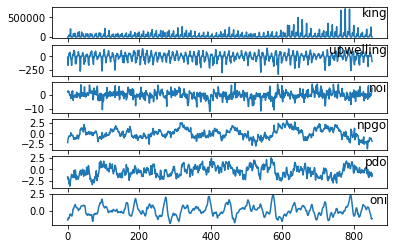

In [108]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [109]:
# convert series to supervised learning
# series_to_supervised from Jason Brownlee's "Multivariate Time Series Forecasting in Keras"
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [110]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [111]:
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [112]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/1000
8/8 - 3s - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2023
Epoch 2/1000
8/8 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1983
Epoch 3/1000
8/8 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1929
Epoch 4/1000
8/8 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944
Epoch 5/1000
8/8 - 0s - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1900
Epoch 6/1000
8/8 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0886 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 7/1000
8/8 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 8/1000
8/8 - 0s - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0348 - val_root_mea

Epoch 40/1000
8/8 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0695 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1578
Epoch 41/1000
8/8 - 0s - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1569
Epoch 42/1000
8/8 - 0s - loss: 0.0046 - root_mean_squared_error: 0.0677 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1558
Epoch 43/1000
8/8 - 0s - loss: 0.0045 - root_mean_squared_error: 0.0670 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1545
Epoch 44/1000
8/8 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1532
Epoch 45/1000
8/8 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1521
Epoch 46/1000
8/8 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1512
Epoch 47/1000
8/8 - 0s - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0227 - val_

Epoch 79/1000
8/8 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0555 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1274
Epoch 80/1000
8/8 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0565 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1271
Epoch 81/1000
8/8 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0572 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1283
Epoch 82/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1264
Epoch 83/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0544 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1247
Epoch 84/1000
8/8 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0569 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1246
Epoch 85/1000
8/8 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0555 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1260
Epoch 86/1000
8/8 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.0151 - val_

Epoch 118/1000
8/8 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 119/1000
8/8 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 120/1000
8/8 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 121/1000
8/8 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 122/1000
8/8 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 123/1000
8/8 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1015
Epoch 124/1000
8/8 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1014
Epoch 125/1000
8/8 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0447 - val_loss: 0.010

Epoch 157/1000
8/8 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 158/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858
Epoch 159/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0877
Epoch 160/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885
Epoch 161/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 162/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 163/1000
8/8 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0877
Epoch 164/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.007

Epoch 195/1000
8/8 - 0s - loss: 9.5571e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0725
Epoch 196/1000
8/8 - 0s - loss: 9.6568e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0709
Epoch 197/1000
8/8 - 0s - loss: 8.8447e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 198/1000
8/8 - 0s - loss: 8.1300e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0696
Epoch 199/1000
8/8 - 0s - loss: 7.6942e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0686
Epoch 200/1000
8/8 - 0s - loss: 7.5727e-04 - root_mean_squared_error: 0.0275 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 201/1000
8/8 - 0s - loss: 7.8614e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 202/1000
8/8 - 0s - loss: 7.7747e-04 - root_mean_squared

Epoch 233/1000
8/8 - 0s - loss: 6.6962e-04 - root_mean_squared_error: 0.0259 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0560
Epoch 234/1000
8/8 - 0s - loss: 8.8168e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 235/1000
8/8 - 0s - loss: 8.6639e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 236/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599
Epoch 237/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 238/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0605
Epoch 239/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0604
Epoch 240/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0365 - val

8/8 - 0s - loss: 3.9208e-04 - root_mean_squared_error: 0.0198 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 272/1000
8/8 - 0s - loss: 3.7445e-04 - root_mean_squared_error: 0.0194 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 273/1000
8/8 - 0s - loss: 3.6639e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 274/1000
8/8 - 0s - loss: 3.6617e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 275/1000
8/8 - 0s - loss: 3.6556e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 276/1000
8/8 - 0s - loss: 3.7019e-04 - root_mean_squared_error: 0.0192 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 277/1000
8/8 - 0s - loss: 3.6301e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 278/1000
8/8 - 0s - loss: 3.6487e-04 - root_mean_squared_error: 0.0191 

Epoch 309/1000
8/8 - 0s - loss: 2.6220e-04 - root_mean_squared_error: 0.0162 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 310/1000
8/8 - 0s - loss: 2.7073e-04 - root_mean_squared_error: 0.0165 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 311/1000
8/8 - 0s - loss: 2.9599e-04 - root_mean_squared_error: 0.0172 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 312/1000
8/8 - 0s - loss: 2.9600e-04 - root_mean_squared_error: 0.0172 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 313/1000
8/8 - 0s - loss: 2.7291e-04 - root_mean_squared_error: 0.0165 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 314/1000
8/8 - 0s - loss: 2.8079e-04 - root_mean_squared_error: 0.0168 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 315/1000
8/8 - 0s - loss: 3.3179e-04 - root_mean_squared_error: 0.0182 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 316/1000
8/8 - 0s - loss: 3.2377e-04 - root_mean_squared

Epoch 347/1000
8/8 - 0s - loss: 2.4672e-04 - root_mean_squared_error: 0.0157 - val_loss: 8.1254e-04 - val_root_mean_squared_error: 0.0285
Epoch 348/1000
8/8 - 0s - loss: 3.3231e-04 - root_mean_squared_error: 0.0182 - val_loss: 9.4248e-04 - val_root_mean_squared_error: 0.0307
Epoch 349/1000
8/8 - 0s - loss: 3.4854e-04 - root_mean_squared_error: 0.0187 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 350/1000
8/8 - 0s - loss: 3.7812e-04 - root_mean_squared_error: 0.0194 - val_loss: 9.4820e-04 - val_root_mean_squared_error: 0.0308
Epoch 351/1000
8/8 - 0s - loss: 2.9125e-04 - root_mean_squared_error: 0.0171 - val_loss: 8.8562e-04 - val_root_mean_squared_error: 0.0298
Epoch 352/1000
8/8 - 0s - loss: 2.8584e-04 - root_mean_squared_error: 0.0169 - val_loss: 8.4053e-04 - val_root_mean_squared_error: 0.0290
Epoch 353/1000
8/8 - 0s - loss: 3.4327e-04 - root_mean_squared_error: 0.0185 - val_loss: 8.9247e-04 - val_root_mean_squared_error: 0.0299
Epoch 354/1000
8/8 - 0s - loss: 3.2188

Epoch 385/1000
8/8 - 0s - loss: 1.7567e-04 - root_mean_squared_error: 0.0133 - val_loss: 5.4621e-04 - val_root_mean_squared_error: 0.0234
Epoch 386/1000
8/8 - 0s - loss: 1.6423e-04 - root_mean_squared_error: 0.0128 - val_loss: 5.0314e-04 - val_root_mean_squared_error: 0.0224
Epoch 387/1000
8/8 - 0s - loss: 1.3911e-04 - root_mean_squared_error: 0.0118 - val_loss: 4.9026e-04 - val_root_mean_squared_error: 0.0221
Epoch 388/1000
8/8 - 0s - loss: 1.3503e-04 - root_mean_squared_error: 0.0116 - val_loss: 4.6437e-04 - val_root_mean_squared_error: 0.0215
Epoch 389/1000
8/8 - 0s - loss: 1.2562e-04 - root_mean_squared_error: 0.0112 - val_loss: 4.6352e-04 - val_root_mean_squared_error: 0.0215
Epoch 390/1000
8/8 - 0s - loss: 1.3101e-04 - root_mean_squared_error: 0.0114 - val_loss: 4.5292e-04 - val_root_mean_squared_error: 0.0213
Epoch 391/1000
8/8 - 0s - loss: 1.6638e-04 - root_mean_squared_error: 0.0129 - val_loss: 4.8454e-04 - val_root_mean_squared_error: 0.0220
Epoch 392/1000
8/8 - 0s - loss: 1.

Epoch 422/1000
8/8 - 0s - loss: 1.7437e-04 - root_mean_squared_error: 0.0132 - val_loss: 3.6994e-04 - val_root_mean_squared_error: 0.0192
Epoch 423/1000
8/8 - 0s - loss: 1.9246e-04 - root_mean_squared_error: 0.0139 - val_loss: 4.0662e-04 - val_root_mean_squared_error: 0.0202
Epoch 424/1000
8/8 - 0s - loss: 2.0656e-04 - root_mean_squared_error: 0.0144 - val_loss: 3.5873e-04 - val_root_mean_squared_error: 0.0189
Epoch 425/1000
8/8 - 0s - loss: 2.3355e-04 - root_mean_squared_error: 0.0153 - val_loss: 5.2895e-04 - val_root_mean_squared_error: 0.0230
Epoch 426/1000
8/8 - 0s - loss: 2.1027e-04 - root_mean_squared_error: 0.0145 - val_loss: 3.9575e-04 - val_root_mean_squared_error: 0.0199
Epoch 427/1000
8/8 - 0s - loss: 2.0541e-04 - root_mean_squared_error: 0.0143 - val_loss: 3.1340e-04 - val_root_mean_squared_error: 0.0177
Epoch 428/1000
8/8 - 0s - loss: 2.0533e-04 - root_mean_squared_error: 0.0143 - val_loss: 3.3227e-04 - val_root_mean_squared_error: 0.0182
Epoch 429/1000
8/8 - 0s - loss: 2.

Epoch 460/1000
8/8 - 0s - loss: 2.4059e-04 - root_mean_squared_error: 0.0155 - val_loss: 3.3127e-04 - val_root_mean_squared_error: 0.0182
Epoch 461/1000
8/8 - 0s - loss: 2.6388e-04 - root_mean_squared_error: 0.0162 - val_loss: 4.3444e-04 - val_root_mean_squared_error: 0.0208
Epoch 462/1000
8/8 - 0s - loss: 2.5659e-04 - root_mean_squared_error: 0.0160 - val_loss: 3.5771e-04 - val_root_mean_squared_error: 0.0189
Epoch 463/1000
8/8 - 0s - loss: 2.1928e-04 - root_mean_squared_error: 0.0148 - val_loss: 2.2687e-04 - val_root_mean_squared_error: 0.0151
Epoch 464/1000
8/8 - 0s - loss: 2.3282e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.2835e-04 - val_root_mean_squared_error: 0.0181
Epoch 465/1000
8/8 - 0s - loss: 2.2256e-04 - root_mean_squared_error: 0.0149 - val_loss: 3.8465e-04 - val_root_mean_squared_error: 0.0196
Epoch 466/1000
8/8 - 0s - loss: 2.8230e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.0125e-04 - val_root_mean_squared_error: 0.0174
Epoch 467/1000
8/8 - 0s - loss: 3.

Epoch 497/1000
8/8 - 0s - loss: 7.9665e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.6007e-04 - val_root_mean_squared_error: 0.0127
Epoch 498/1000
8/8 - 0s - loss: 7.7504e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.5143e-04 - val_root_mean_squared_error: 0.0123
Epoch 499/1000
8/8 - 0s - loss: 7.7057e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.5898e-04 - val_root_mean_squared_error: 0.0126
Epoch 500/1000
8/8 - 0s - loss: 7.0320e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.4674e-04 - val_root_mean_squared_error: 0.0121
Epoch 501/1000
8/8 - 0s - loss: 6.8068e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.4634e-04 - val_root_mean_squared_error: 0.0121
Epoch 502/1000
8/8 - 0s - loss: 6.2563e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.3579e-04 - val_root_mean_squared_error: 0.0117
Epoch 503/1000
8/8 - 0s - loss: 5.7546e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.2040e-04 - val_root_mean_squared_error: 0.0110
Epoch 504/1000
8/8 - 0s - loss: 5.

Epoch 535/1000
8/8 - 0s - loss: 3.0592e-04 - root_mean_squared_error: 0.0175 - val_loss: 3.2390e-04 - val_root_mean_squared_error: 0.0180
Epoch 536/1000
8/8 - 0s - loss: 2.7187e-04 - root_mean_squared_error: 0.0165 - val_loss: 1.7844e-04 - val_root_mean_squared_error: 0.0134
Epoch 537/1000
8/8 - 0s - loss: 2.1983e-04 - root_mean_squared_error: 0.0148 - val_loss: 2.2824e-04 - val_root_mean_squared_error: 0.0151
Epoch 538/1000
8/8 - 0s - loss: 1.9850e-04 - root_mean_squared_error: 0.0141 - val_loss: 2.1682e-04 - val_root_mean_squared_error: 0.0147
Epoch 539/1000
8/8 - 0s - loss: 1.8954e-04 - root_mean_squared_error: 0.0138 - val_loss: 2.2123e-04 - val_root_mean_squared_error: 0.0149
Epoch 540/1000
8/8 - 0s - loss: 1.6051e-04 - root_mean_squared_error: 0.0127 - val_loss: 2.5392e-04 - val_root_mean_squared_error: 0.0159
Epoch 541/1000
8/8 - 0s - loss: 1.0042e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.6708e-04 - val_root_mean_squared_error: 0.0129
Epoch 542/1000
8/8 - 0s - loss: 9.

Epoch 572/1000
8/8 - 0s - loss: 7.9047e-05 - root_mean_squared_error: 0.0089 - val_loss: 8.9366e-05 - val_root_mean_squared_error: 0.0095
Epoch 573/1000
8/8 - 0s - loss: 7.3826e-05 - root_mean_squared_error: 0.0086 - val_loss: 9.2226e-05 - val_root_mean_squared_error: 0.0096
Epoch 574/1000
8/8 - 0s - loss: 7.6655e-05 - root_mean_squared_error: 0.0088 - val_loss: 9.9456e-05 - val_root_mean_squared_error: 0.0100
Epoch 575/1000
8/8 - 0s - loss: 8.9108e-05 - root_mean_squared_error: 0.0094 - val_loss: 9.5983e-05 - val_root_mean_squared_error: 0.0098
Epoch 576/1000
8/8 - 0s - loss: 1.1819e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.3780e-04 - val_root_mean_squared_error: 0.0117
Epoch 577/1000
8/8 - 0s - loss: 1.0916e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.0865e-04 - val_root_mean_squared_error: 0.0104
Epoch 578/1000
8/8 - 0s - loss: 1.0711e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.1689e-04 - val_root_mean_squared_error: 0.0108
Epoch 579/1000
8/8 - 0s - loss: 1.

Epoch 610/1000
8/8 - 0s - loss: 3.0556e-04 - root_mean_squared_error: 0.0175 - val_loss: 3.8136e-04 - val_root_mean_squared_error: 0.0195
Epoch 611/1000
8/8 - 0s - loss: 3.5153e-04 - root_mean_squared_error: 0.0187 - val_loss: 3.7615e-04 - val_root_mean_squared_error: 0.0194
Epoch 612/1000
8/8 - 0s - loss: 2.3703e-04 - root_mean_squared_error: 0.0154 - val_loss: 1.9225e-04 - val_root_mean_squared_error: 0.0139
Epoch 613/1000
8/8 - 0s - loss: 1.9151e-04 - root_mean_squared_error: 0.0138 - val_loss: 2.5818e-04 - val_root_mean_squared_error: 0.0161
Epoch 614/1000
8/8 - 0s - loss: 1.6096e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.2744e-04 - val_root_mean_squared_error: 0.0113
Epoch 615/1000
8/8 - 0s - loss: 1.3329e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.6300e-04 - val_root_mean_squared_error: 0.0128
Epoch 616/1000
8/8 - 0s - loss: 1.0784e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.0967e-04 - val_root_mean_squared_error: 0.0105
Epoch 617/1000
8/8 - 0s - loss: 1.

Epoch 647/1000
8/8 - 0s - loss: 5.0999e-05 - root_mean_squared_error: 0.0071 - val_loss: 5.0218e-05 - val_root_mean_squared_error: 0.0071
Epoch 648/1000
8/8 - 0s - loss: 5.5625e-05 - root_mean_squared_error: 0.0075 - val_loss: 6.6786e-05 - val_root_mean_squared_error: 0.0082
Epoch 649/1000
8/8 - 0s - loss: 4.2477e-05 - root_mean_squared_error: 0.0065 - val_loss: 3.0559e-05 - val_root_mean_squared_error: 0.0055
Epoch 650/1000
8/8 - 0s - loss: 4.2423e-05 - root_mean_squared_error: 0.0065 - val_loss: 4.3539e-05 - val_root_mean_squared_error: 0.0066
Epoch 651/1000
8/8 - 0s - loss: 3.8124e-05 - root_mean_squared_error: 0.0062 - val_loss: 4.0051e-05 - val_root_mean_squared_error: 0.0063
Epoch 652/1000
8/8 - 0s - loss: 3.9212e-05 - root_mean_squared_error: 0.0063 - val_loss: 4.2770e-05 - val_root_mean_squared_error: 0.0065
Epoch 653/1000
8/8 - 0s - loss: 4.0653e-05 - root_mean_squared_error: 0.0064 - val_loss: 5.1009e-05 - val_root_mean_squared_error: 0.0071
Epoch 654/1000
8/8 - 0s - loss: 5.

Epoch 685/1000
8/8 - 0s - loss: 6.2038e-05 - root_mean_squared_error: 0.0079 - val_loss: 5.6101e-05 - val_root_mean_squared_error: 0.0075
Epoch 686/1000
8/8 - 0s - loss: 7.7672e-05 - root_mean_squared_error: 0.0088 - val_loss: 8.2291e-05 - val_root_mean_squared_error: 0.0091
Epoch 687/1000
8/8 - 0s - loss: 8.0998e-05 - root_mean_squared_error: 0.0090 - val_loss: 6.9232e-05 - val_root_mean_squared_error: 0.0083
Epoch 688/1000
8/8 - 0s - loss: 6.9354e-05 - root_mean_squared_error: 0.0083 - val_loss: 6.0514e-05 - val_root_mean_squared_error: 0.0078
Epoch 689/1000
8/8 - 0s - loss: 6.4015e-05 - root_mean_squared_error: 0.0080 - val_loss: 5.0173e-05 - val_root_mean_squared_error: 0.0071
Epoch 690/1000
8/8 - 0s - loss: 6.8907e-05 - root_mean_squared_error: 0.0083 - val_loss: 6.3200e-05 - val_root_mean_squared_error: 0.0079
Epoch 691/1000
8/8 - 0s - loss: 8.1165e-05 - root_mean_squared_error: 0.0090 - val_loss: 8.1322e-05 - val_root_mean_squared_error: 0.0090
Epoch 692/1000
8/8 - 0s - loss: 1.

Epoch 722/1000
8/8 - 0s - loss: 3.6744e-05 - root_mean_squared_error: 0.0061 - val_loss: 3.2876e-05 - val_root_mean_squared_error: 0.0057
Epoch 723/1000
8/8 - 0s - loss: 3.8455e-05 - root_mean_squared_error: 0.0062 - val_loss: 3.6622e-05 - val_root_mean_squared_error: 0.0061
Epoch 724/1000
8/8 - 0s - loss: 3.4448e-05 - root_mean_squared_error: 0.0059 - val_loss: 3.1808e-05 - val_root_mean_squared_error: 0.0056
Epoch 725/1000
8/8 - 0s - loss: 3.1155e-05 - root_mean_squared_error: 0.0056 - val_loss: 3.4094e-05 - val_root_mean_squared_error: 0.0058
Epoch 726/1000
8/8 - 0s - loss: 3.9915e-05 - root_mean_squared_error: 0.0063 - val_loss: 3.6207e-05 - val_root_mean_squared_error: 0.0060
Epoch 727/1000
8/8 - 0s - loss: 4.1309e-05 - root_mean_squared_error: 0.0064 - val_loss: 2.8889e-05 - val_root_mean_squared_error: 0.0054
Epoch 728/1000
8/8 - 0s - loss: 2.8091e-05 - root_mean_squared_error: 0.0053 - val_loss: 2.7071e-05 - val_root_mean_squared_error: 0.0052
Epoch 729/1000
8/8 - 0s - loss: 2.

Epoch 760/1000
8/8 - 0s - loss: 1.8496e-04 - root_mean_squared_error: 0.0136 - val_loss: 1.4512e-04 - val_root_mean_squared_error: 0.0120
Epoch 761/1000
8/8 - 0s - loss: 1.7964e-04 - root_mean_squared_error: 0.0134 - val_loss: 9.4805e-05 - val_root_mean_squared_error: 0.0097
Epoch 762/1000
8/8 - 0s - loss: 1.8515e-04 - root_mean_squared_error: 0.0136 - val_loss: 1.2634e-04 - val_root_mean_squared_error: 0.0112
Epoch 763/1000
8/8 - 0s - loss: 1.6666e-04 - root_mean_squared_error: 0.0129 - val_loss: 1.2928e-04 - val_root_mean_squared_error: 0.0114
Epoch 764/1000
8/8 - 0s - loss: 2.4350e-04 - root_mean_squared_error: 0.0156 - val_loss: 1.6024e-04 - val_root_mean_squared_error: 0.0127
Epoch 765/1000
8/8 - 0s - loss: 2.5257e-04 - root_mean_squared_error: 0.0159 - val_loss: 2.2904e-04 - val_root_mean_squared_error: 0.0151
Epoch 766/1000
8/8 - 0s - loss: 2.4894e-04 - root_mean_squared_error: 0.0158 - val_loss: 1.9579e-04 - val_root_mean_squared_error: 0.0140
Epoch 767/1000
8/8 - 0s - loss: 2.

Epoch 797/1000
8/8 - 0s - loss: 2.4446e-05 - root_mean_squared_error: 0.0049 - val_loss: 1.9998e-05 - val_root_mean_squared_error: 0.0045
Epoch 798/1000
8/8 - 0s - loss: 2.4327e-05 - root_mean_squared_error: 0.0049 - val_loss: 1.9075e-05 - val_root_mean_squared_error: 0.0044
Epoch 799/1000
8/8 - 0s - loss: 2.6520e-05 - root_mean_squared_error: 0.0051 - val_loss: 2.7350e-05 - val_root_mean_squared_error: 0.0052
Epoch 800/1000
8/8 - 0s - loss: 2.7459e-05 - root_mean_squared_error: 0.0052 - val_loss: 2.5253e-05 - val_root_mean_squared_error: 0.0050
Epoch 801/1000
8/8 - 0s - loss: 2.6364e-05 - root_mean_squared_error: 0.0051 - val_loss: 2.3362e-05 - val_root_mean_squared_error: 0.0048
Epoch 802/1000
8/8 - 0s - loss: 3.0160e-05 - root_mean_squared_error: 0.0055 - val_loss: 2.0507e-05 - val_root_mean_squared_error: 0.0045
Epoch 803/1000
8/8 - 0s - loss: 4.5349e-05 - root_mean_squared_error: 0.0067 - val_loss: 3.3733e-05 - val_root_mean_squared_error: 0.0058
Epoch 804/1000
8/8 - 0s - loss: 5.

Epoch 835/1000
8/8 - 0s - loss: 2.3457e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.2908e-04 - val_root_mean_squared_error: 0.0151
Epoch 836/1000
8/8 - 0s - loss: 1.9157e-04 - root_mean_squared_error: 0.0138 - val_loss: 2.1748e-04 - val_root_mean_squared_error: 0.0147
Epoch 837/1000
8/8 - 0s - loss: 1.8356e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.5214e-04 - val_root_mean_squared_error: 0.0123
Epoch 838/1000
8/8 - 0s - loss: 1.5844e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.4575e-04 - val_root_mean_squared_error: 0.0121
Epoch 839/1000
8/8 - 0s - loss: 1.0326e-04 - root_mean_squared_error: 0.0102 - val_loss: 8.2772e-05 - val_root_mean_squared_error: 0.0091
Epoch 840/1000
8/8 - 0s - loss: 1.0555e-04 - root_mean_squared_error: 0.0103 - val_loss: 7.4220e-05 - val_root_mean_squared_error: 0.0086
Epoch 841/1000
8/8 - 0s - loss: 8.7467e-05 - root_mean_squared_error: 0.0094 - val_loss: 9.0096e-05 - val_root_mean_squared_error: 0.0095
Epoch 842/1000
8/8 - 0s - loss: 8.

Epoch 872/1000
8/8 - 0s - loss: 1.8957e-05 - root_mean_squared_error: 0.0044 - val_loss: 1.7446e-05 - val_root_mean_squared_error: 0.0042
Epoch 873/1000
8/8 - 0s - loss: 1.5801e-05 - root_mean_squared_error: 0.0040 - val_loss: 1.6917e-05 - val_root_mean_squared_error: 0.0041
Epoch 874/1000
8/8 - 0s - loss: 1.7115e-05 - root_mean_squared_error: 0.0041 - val_loss: 1.4879e-05 - val_root_mean_squared_error: 0.0039
Epoch 875/1000
8/8 - 0s - loss: 1.9370e-05 - root_mean_squared_error: 0.0044 - val_loss: 1.5559e-05 - val_root_mean_squared_error: 0.0039
Epoch 876/1000
8/8 - 0s - loss: 2.6590e-05 - root_mean_squared_error: 0.0052 - val_loss: 2.1215e-05 - val_root_mean_squared_error: 0.0046
Epoch 877/1000
8/8 - 0s - loss: 3.2839e-05 - root_mean_squared_error: 0.0057 - val_loss: 3.1885e-05 - val_root_mean_squared_error: 0.0056
Epoch 878/1000
8/8 - 0s - loss: 3.8788e-05 - root_mean_squared_error: 0.0062 - val_loss: 3.1390e-05 - val_root_mean_squared_error: 0.0056
Epoch 879/1000
8/8 - 0s - loss: 3.

Epoch 910/1000
8/8 - 0s - loss: 1.1197e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.1151e-04 - val_root_mean_squared_error: 0.0106
Epoch 911/1000
8/8 - 0s - loss: 1.1762e-04 - root_mean_squared_error: 0.0108 - val_loss: 6.4630e-05 - val_root_mean_squared_error: 0.0080
Epoch 912/1000
8/8 - 0s - loss: 1.8830e-04 - root_mean_squared_error: 0.0137 - val_loss: 1.3347e-04 - val_root_mean_squared_error: 0.0116
Epoch 913/1000
8/8 - 0s - loss: 1.7176e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.1798e-04 - val_root_mean_squared_error: 0.0148
Epoch 914/1000
8/8 - 0s - loss: 1.4644e-04 - root_mean_squared_error: 0.0121 - val_loss: 9.3872e-05 - val_root_mean_squared_error: 0.0097
Epoch 915/1000
8/8 - 0s - loss: 1.0159e-04 - root_mean_squared_error: 0.0101 - val_loss: 8.1890e-05 - val_root_mean_squared_error: 0.0090
Epoch 916/1000
8/8 - 0s - loss: 1.0674e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.2189e-04 - val_root_mean_squared_error: 0.0110
Epoch 917/1000
8/8 - 0s - loss: 1.

Epoch 947/1000
8/8 - 0s - loss: 6.2973e-05 - root_mean_squared_error: 0.0079 - val_loss: 3.5883e-05 - val_root_mean_squared_error: 0.0060
Epoch 948/1000
8/8 - 0s - loss: 6.5291e-05 - root_mean_squared_error: 0.0081 - val_loss: 6.2234e-05 - val_root_mean_squared_error: 0.0079
Epoch 949/1000
8/8 - 0s - loss: 8.0685e-05 - root_mean_squared_error: 0.0090 - val_loss: 6.1080e-05 - val_root_mean_squared_error: 0.0078
Epoch 950/1000
8/8 - 0s - loss: 8.0729e-05 - root_mean_squared_error: 0.0090 - val_loss: 7.3084e-05 - val_root_mean_squared_error: 0.0085
Epoch 951/1000
8/8 - 0s - loss: 9.3224e-05 - root_mean_squared_error: 0.0097 - val_loss: 6.2410e-05 - val_root_mean_squared_error: 0.0079
Epoch 952/1000
8/8 - 0s - loss: 9.4520e-05 - root_mean_squared_error: 0.0097 - val_loss: 5.0591e-05 - val_root_mean_squared_error: 0.0071
Epoch 953/1000
8/8 - 0s - loss: 9.5749e-05 - root_mean_squared_error: 0.0098 - val_loss: 7.9139e-05 - val_root_mean_squared_error: 0.0089
Epoch 954/1000
8/8 - 0s - loss: 1.

Epoch 985/1000
8/8 - 0s - loss: 8.1943e-05 - root_mean_squared_error: 0.0091 - val_loss: 4.7275e-05 - val_root_mean_squared_error: 0.0069
Epoch 986/1000
8/8 - 0s - loss: 8.9102e-05 - root_mean_squared_error: 0.0094 - val_loss: 4.8187e-05 - val_root_mean_squared_error: 0.0069
Epoch 987/1000
8/8 - 0s - loss: 1.4367e-04 - root_mean_squared_error: 0.0120 - val_loss: 9.4286e-05 - val_root_mean_squared_error: 0.0097
Epoch 988/1000
8/8 - 0s - loss: 1.4955e-04 - root_mean_squared_error: 0.0122 - val_loss: 1.1760e-04 - val_root_mean_squared_error: 0.0108
Epoch 989/1000
8/8 - 0s - loss: 1.5798e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.2528e-04 - val_root_mean_squared_error: 0.0112
Epoch 990/1000
8/8 - 0s - loss: 1.3258e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.0305e-04 - val_root_mean_squared_error: 0.0102
Epoch 991/1000
8/8 - 0s - loss: 1.5237e-04 - root_mean_squared_error: 0.0123 - val_loss: 6.4503e-05 - val_root_mean_squared_error: 0.0080
Epoch 992/1000
8/8 - 0s - loss: 1.

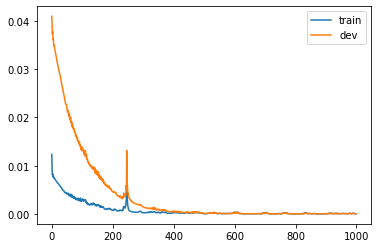

In [113]:
# design network
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=1000, batch_size=100, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [114]:
# make a prediction
yhat = model.predict(test_X)
train_yhat = model.predict(train_X)

In [115]:
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))
train_X = train_X.reshape((train_X.shape[0], n_months*n_features))

In [116]:
# invert scaling for forecast
inv_yhat_train = concatenate((train_yhat, train_X[:, -5:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_train = concatenate((train_y, train_X[:, -5:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]

In [117]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [118]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The test root mean squared error is {}.".format(rmse))

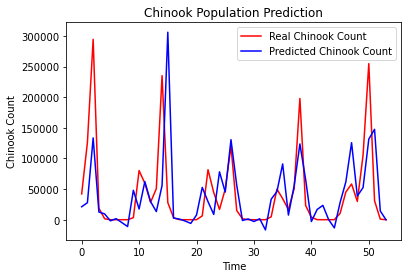

The test root mean squared error is 63095.492327106855.


In [119]:
plot_predictions(inv_y, inv_yhat)
return_rmse(inv_y, inv_yhat)

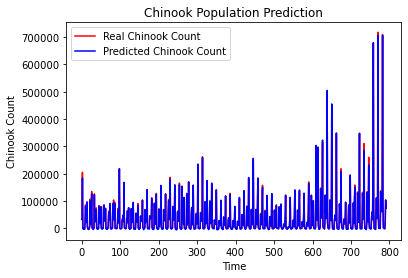

The test root mean squared error is 3160.4812924616404.


In [120]:
plot_predictions(inv_y_train, inv_yhat_train)
return_rmse(inv_y_train, inv_yhat_train)

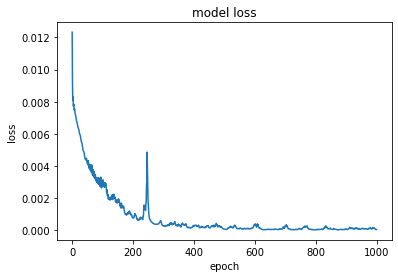

In [121]:
plot_loss(history)

In [122]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  521984
1  400838
2  418377
3  610318
    Count
0  488981
1  336030
2  381773
3  535746


In [123]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [124]:
return_rmse(actual, traditional)

The test root mean squared error is 115829.72216361394.


In [125]:
return_rmse(actual, preds)

The test root mean squared error is 55204.417561006834.
